In [5]:
import pandas as pd
import numpy as np
import os
import time
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import load_npz
from tqdm import tqdm
import matplotlib.pyplot as plt

In [6]:

def clean_title(title):
    title = re.sub("[^a-zA-Z0-9 ]", "", title)
    return title

In [7]:
user_movie_matrix = pd.read_csv(os.path.join("..","output","collbarfilter.csv"))
user_similarity = pd.read_csv(os.path.join("..","output","UtU_similarityMatrix.csv")).iloc[:,1:]
movies = pd.read_csv(os.path.join("..","data","movies.csv"))
ratings = pd.read_csv(os.path.join("..","data","ratings.csv"))

movies["clean_title"] = movies["title"].apply(clean_title)

In [8]:
user_similarity

,0,1,2,3,4,5,6,7,8,9,...,600,601,602,603,604,605,606,607,608,609
0,0.000000,0.000000,0.0,0.932810,0.970770,0.939243,0.951037,0.978123,0.000000,0.000000,...,0.992413,0.958830,0.927490,0.954033,0.937549,0.967379,0.958247,0.956573,0.000000,0.976881
1,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.981042,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.990501
2,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.932810,0.000000,0.0,0.000000,0.901137,0.899828,0.945977,0.000000,0.000000,0.000000,...,0.879535,0.918902,0.912397,0.000000,0.952565,0.933792,0.913567,0.867322,0.000000,0.921235
4,0.970770,0.000000,0.0,0.901137,0.000000,0.932712,0.000000,0.943665,0.000000,0.000000,...,0.000000,0.939417,0.933872,0.954653,0.930918,0.960953,0.954314,0.928047,0.979824,0.960010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.967379,0.000000,0.0,0.933792,0.960953,0.947985,0.931303,0.967077,0.977616,0.902706,...,0.989826,0.946998,0.951495,0.980066,0.966624,0.000000,0.952440,0.950909,0.985496,0.975492
606,0.958247,0.000000,0.0,0.913567,0.954314,0.961672,0.972062,0.963498,0.000000,0.000000,...,0.994381,0.955249,0.923803,0.958146,0.932317,0.952440,0.000000,0.952135,0.979129,0.959225
607,0.956573,0.000000,0.0,0.867322,0.928047,0.911192,0.922770,0.959250,0.939601,0.852762,...,0.979492,0.946875,0.915620,0.926622,0.929948,0.950909,0.952135,0.000000,0.972303,0.957767
608,0.000000,0.000000,0.0,0.000000,0.979824,0.965591,0.000000,0.967007,0.000000,0.000000,...,0.000000,0.968857,0.945054,0.987983,0.000000,0.985496,0.979129,0.972303,0.000000,0.963104


In [9]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))

tfidf = vectorizer.fit_transform(movies["clean_title"])


def search(title):
    title = clean_title(title)
    query_vec = vectorizer.transform([title])
    similarity = cosine_similarity(query_vec, tfidf).flatten()
    indices = np.argpartition(similarity, -5)[-5:]
    results = movies.iloc[indices].iloc[::-1]
    

In [10]:
userids = ratings["userId"].unique()
user_similarity.columns = userids
user_similarity.index = userids
user_similarity

,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
1,0.000000,0.000000,0.0,0.932810,0.970770,0.939243,0.951037,0.978123,0.000000,0.000000,...,0.992413,0.958830,0.927490,0.954033,0.937549,0.967379,0.958247,0.956573,0.000000,0.976881
2,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.981042,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.990501
3,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.932810,0.000000,0.0,0.000000,0.901137,0.899828,0.945977,0.000000,0.000000,0.000000,...,0.879535,0.918902,0.912397,0.000000,0.952565,0.933792,0.913567,0.867322,0.000000,0.921235
5,0.970770,0.000000,0.0,0.901137,0.000000,0.932712,0.000000,0.943665,0.000000,0.000000,...,0.000000,0.939417,0.933872,0.954653,0.930918,0.960953,0.954314,0.928047,0.979824,0.960010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.967379,0.000000,0.0,0.933792,0.960953,0.947985,0.931303,0.967077,0.977616,0.902706,...,0.989826,0.946998,0.951495,0.980066,0.966624,0.000000,0.952440,0.950909,0.985496,0.975492
607,0.958247,0.000000,0.0,0.913567,0.954314,0.961672,0.972062,0.963498,0.000000,0.000000,...,0.994381,0.955249,0.923803,0.958146,0.932317,0.952440,0.000000,0.952135,0.979129,0.959225
608,0.956573,0.000000,0.0,0.867322,0.928047,0.911192,0.922770,0.959250,0.939601,0.852762,...,0.979492,0.946875,0.915620,0.926622,0.929948,0.950909,0.952135,0.000000,0.972303,0.957767
609,0.000000,0.000000,0.0,0.000000,0.979824,0.965591,0.000000,0.967007,0.000000,0.000000,...,0.000000,0.968857,0.945054,0.987983,0.000000,0.985496,0.979129,0.972303,0.000000,0.963104


In [11]:
def clean_title(title):
    return re.sub("[^a-zA-Z0-9 ]","", title)

In [12]:
def personRating(user1, user2):
    return user_similarity.loc[user1, user2]

def movieSimilarity(movie_id, user_id):    
    usersSeen= ratings.loc[ratings["movieId"] == movie_id, ["userId", "rating"]]
    
    if usersSeen.shape[0] < 5:
        return
    
    if usersSeen["userId"].isin([user_id]).any():
        print(f"User {user_id} has already seen movie {movie_id}")
        return
    
    similarityScores = []

    
    for user in usersSeen["userId"]:
        similarityScores.append(personRating(user_id, user))
    
    if sum(1 for element in similarityScores if element != 0)< 5:
        return
    
    total_similarity = np.sum(similarityScores)
    
    if total_similarity == 0:
        return
    
    predicted_score = np.dot(usersSeen["rating"], similarityScores)/total_similarity

    
    return predicted_score

In [13]:
class recommendation():
    def __init__(self, SimilarityMatrix, ratings, movies) -> None:
        self.SimilarityMatrix = SimilarityMatrix
        self.ratings = ratings
        self.user = None
        self.movie_id = None
        self.movie_title = None
        self.relevantUsers = None
    
    def run(self, user_id):
        self.user = user_id
        movie_recs = {}
        
        unseen_movies = set(self.ratings["userId"].unique()) - set(self.ratings[ratings["userId"] == self.user]["movieId"])
        for movie in unseen_movies:
            score = movieSimilarity(movie, self.user)
            if score is None or score < 4:
                continue
            movie_recs[movie] = score
        
        movie_recs_pd = pd.DataFrame.from_dict(movie_recs, orient = "index", columns = ["predictedRating"])
        movie_recs_pd = movie_recs_pd.reset_index().rename(columns={'index': 'movieId'})
        movie_recs_pd['movieId'] = movie_recs_pd['movieId'].astype(movies['movieId'].dtype)

        merged_df = pd.merge(movies, movie_recs_pd, on='movieId', how='right')

        return merged_df.sort_values("predictedRating", ascending=False)

In [14]:
recs = recommendation(SimilarityMatrix= user_similarity, ratings = ratings, movies = movies)
movie_recs = recs.run(user_id=300)

In [15]:
movie_recs

,movieId,title,genres,clean_title,predictedRating
9,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,Pulp Fiction 1994,4.413345
12,475,In the Name of the Father (1993),Drama,In the Name of the Father 1993,4.274265
2,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,Usual Suspects The 1995,4.261913
10,306,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama,Three Colors Red Trois couleurs Rouge 1994,4.250992
6,215,Before Sunrise (1995),Drama|Romance,Before Sunrise 1995,4.232707
7,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,Star Wars Episode IV A New Hope 1977,4.138937
3,162,Crumb (1994),Documentary,Crumb 1994,4.096025
8,293,Léon: The Professional (a.k.a. The Professiona...,Action|Crime|Drama|Thriller,Lon The Professional aka The Professional Lon ...,4.093449
1,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,Seven aka Se7en 1995,4.091612
5,194,Smoke (1995),Comedy|Drama,Smoke 1995,4.087043


In [16]:
import ipywidgets as widgets
from IPython.display import display

recs = recommendation(SimilarityMatrix= user_similarity, ratings = ratings, movies = movies)

userid_input = widgets.Text(
    value="",
    description='User Id:',
    disabled=False
)
recommendation_list = widgets.Output()

def on_type(data):
    with recommendation_list:
        recommendation_list.clear_output()
        id = data["new"]
        if id:
            display(recs.run(user_id=int(id)))

userid_input.observe(on_type, names='value')

display(userid_input, recommendation_list)

Text(value='', description='User Id:')

Output()

In [18]:
top_recommendations = []

for i in tqdm(range(610)):
    try:
        recommendation = recs.run(i+1)
        # Ensure that the DataFrame is not empty and the column exists
        if recommendation is not None and "movieId" in recommendation:
            top_recommendations.append(recommendation.iloc[0]["movieId"])
        else:
            top_recommendations.append(None)  # or some placeholder for no recommendation
    except Exception as e:
        print(f"An error occurred for user {i+1}: {e}")
        top_recommendations.append(None) 

  9%|▊         | 53/610 [00:15<02:42,  3.43it/s]

An error occurred for user 53: single positional indexer is out-of-bounds


 23%|██▎       | 138/610 [00:39<02:28,  3.18it/s]

An error occurred for user 138: single positional indexer is out-of-bounds


 29%|██▊       | 175/610 [00:51<02:12,  3.27it/s]

An error occurred for user 175: single positional indexer is out-of-bounds


 52%|█████▏    | 320/610 [01:36<01:27,  3.31it/s]

An error occurred for user 320: single positional indexer is out-of-bounds


 95%|█████████▍| 578/610 [02:53<00:10,  3.14it/s]

An error occurred for user 578: single positional indexer is out-of-bounds


100%|██████████| 610/610 [03:02<00:00,  3.35it/s]


[]

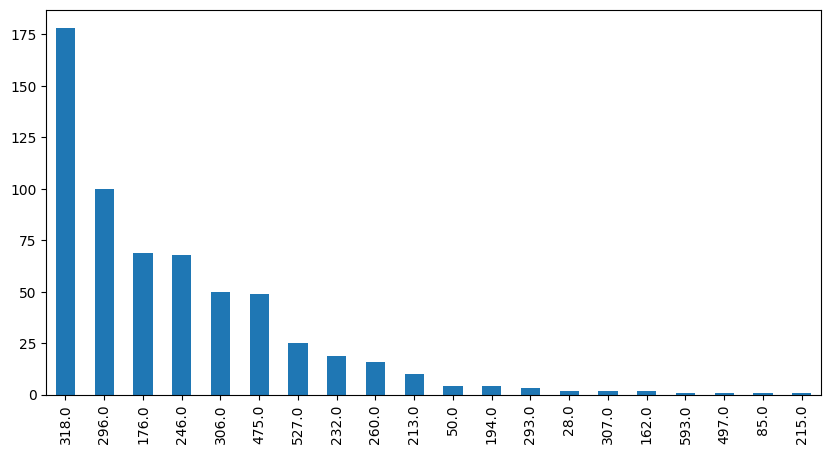

In [20]:
recommend_count = pd.Series(top_recommendations).value_counts()

recommend_count.plot(kind = "bar", figsize=(10, 5))
plt.plot()

In [21]:
recommended = pd.DataFrame(recommend_count).merge(movies, left_index= True, right_on = "movieId", how = "left")
recommended

,count,movieId,title,genres,clean_title
277,178,318,"Shawshank Redemption, The (1994)",Crime|Drama,Shawshank Redemption The 1994
257,100,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,Pulp Fiction 1994
148,69,176,Living in Oblivion (1995),Comedy,Living in Oblivion 1995
210,68,246,Hoop Dreams (1994),Documentary,Hoop Dreams 1994
266,50,306,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama,Three Colors Red Trois couleurs Rouge 1994
413,49,475,In the Name of the Father (1993),Drama,In the Name of the Father 1993
461,25,527,Schindler's List (1993),Drama|War,Schindlers List 1993
198,19,232,Eat Drink Man Woman (Yin shi nan nu) (1994),Comedy|Drama|Romance,Eat Drink Man Woman Yin shi nan nu 1994
224,16,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,Star Wars Episode IV A New Hope 1977
181,10,213,Burnt by the Sun (Utomlyonnye solntsem) (1994),Drama,Burnt by the Sun Utomlyonnye solntsem 1994


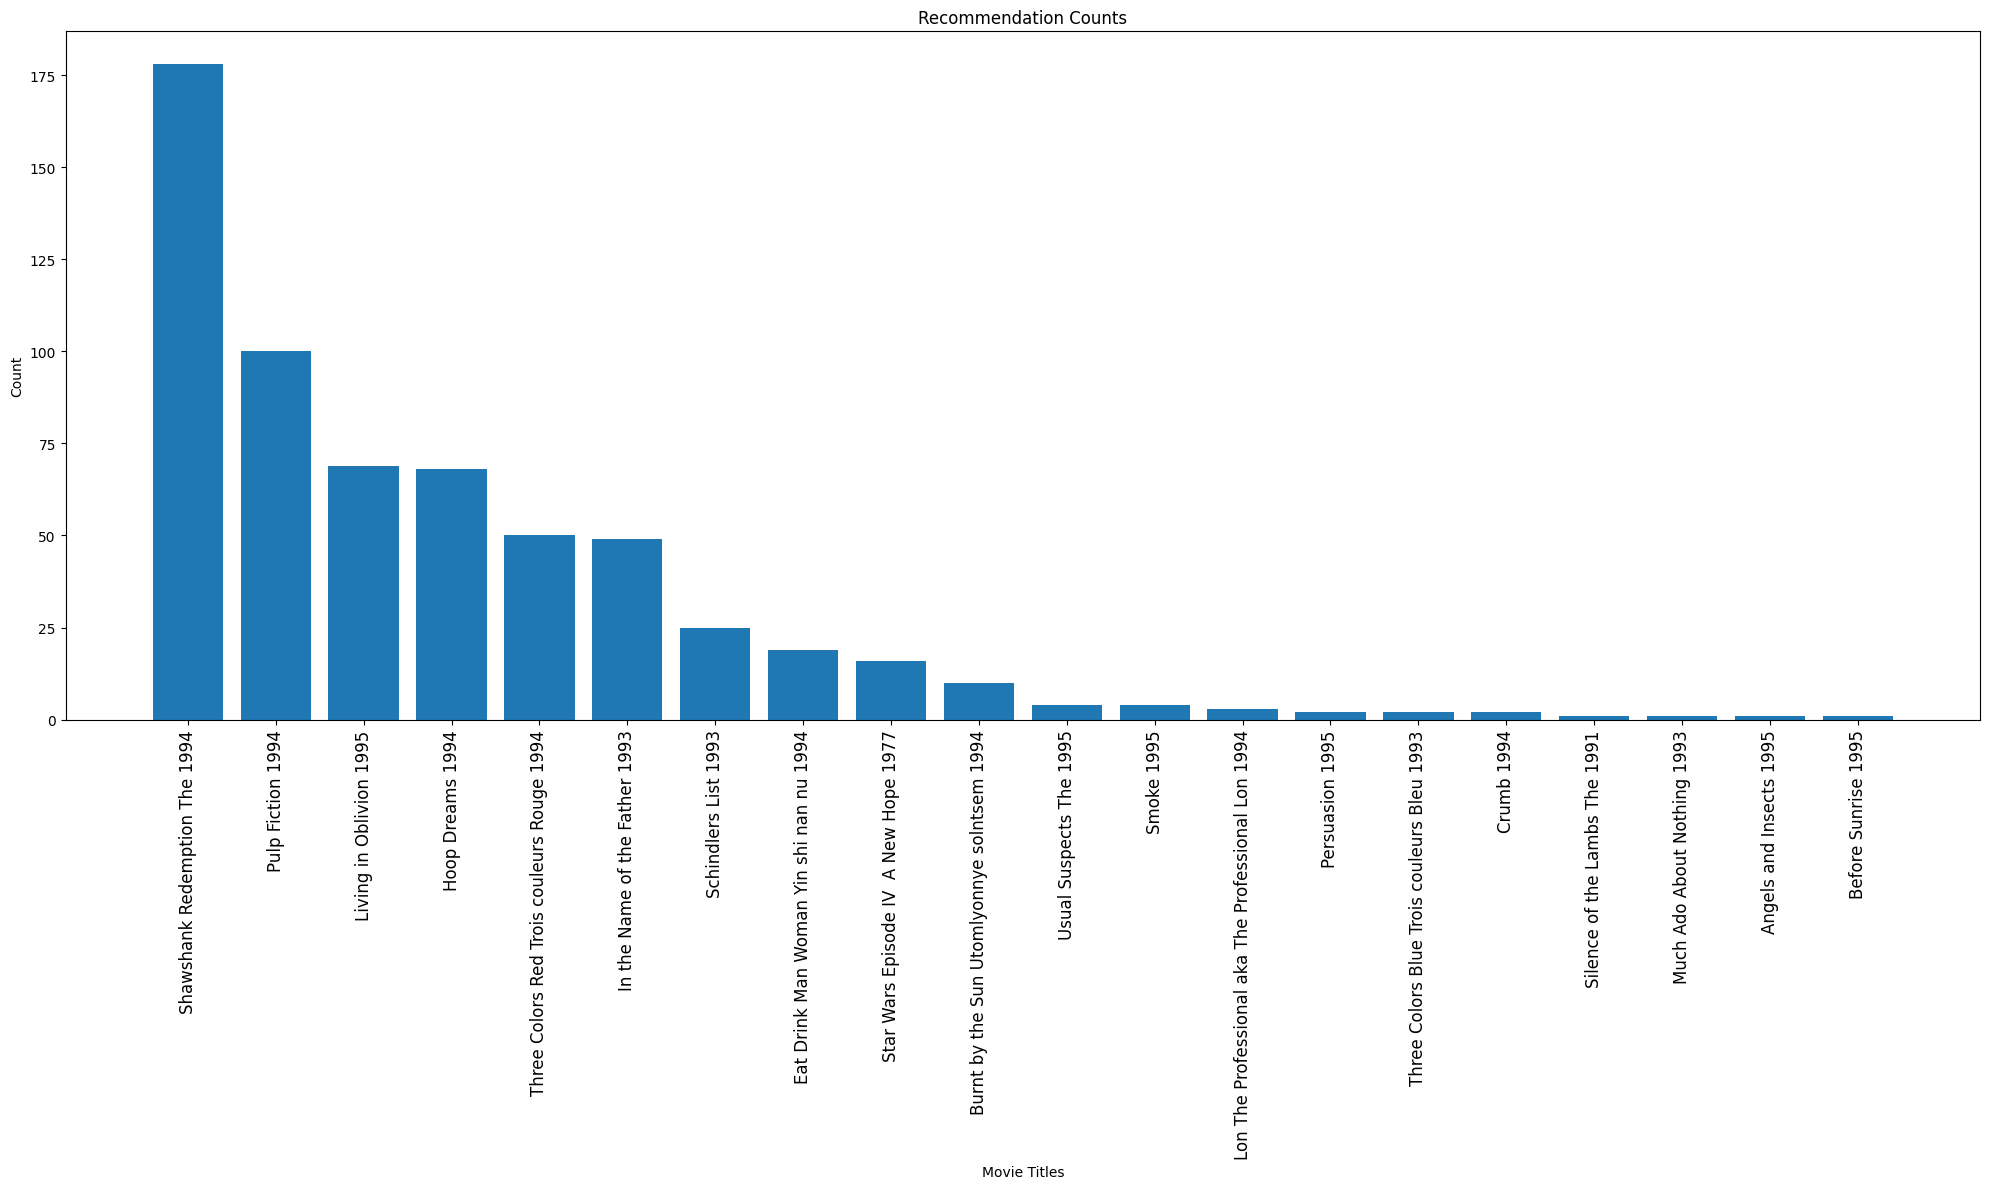

In [22]:
plt.figure(figsize=(20, 12))  # Adjust the width as necessary

# Create the bar plot
plt.bar(x=recommended["clean_title"], height=recommended["count"])

# Set x-ticks: Only label every nth bar to reduce clutter
n = 1  # for example, label every 5th bar
plt.xticks(ticks=range(0, len(recommended["clean_title"]), n), 
           labels=recommended["clean_title"][::n], 
           rotation=90,  # Rotate labels vertically
           fontsize=12)  # Use a smaller font size

# Set the x-axis label
plt.xlabel('Movie Titles')

# Set the y-axis label
plt.ylabel('Count')

# Optional: Add a title to the plot
plt.title('Recommendation Counts')

# Adjust the layout to ensure everything fits
plt.tight_layout()

# Show the plot
plt.show()

In [23]:
ratings[ratings["movieId"] == 334]

,userId,movieId,rating,timestamp
3791,23,334,4.0,1107164085
13149,84,334,4.0,858772079
38213,262,334,3.0,840309968
38911,268,334,5.0,940180612
96186,603,334,5.0,953925002


## Validation Similarity

In [85]:
def movieValidationSimilarity(movie_id, user_id):    
    usersSeen= ratings.loc[ratings["movieId"] == movie_id, ["userId", "rating"]]
    
    if usersSeen["userId"].isin([user_id]).any():
        similarityScores = []
    
        for user in usersSeen["userId"]:
            similarityScores.append(personRating(user_id, user))
        
        if sum(1 for element in similarityScores if element != 0)< 5:
            print(sum(1 for element in similarityScores if element != 0))
            return
        
        total_similarity = np.sum(similarityScores)
        
        if total_similarity == 0:
            return
        
        predicted_score = np.dot(usersSeen["rating"], similarityScores)/total_similarity

        
        return predicted_score
    else:
        return

In [38]:
movie_id = 1
user_id = 1

ratings.loc[(ratings["userId"] == user_id) & (ratings["movieId"] == movie_id), "rating"]

0    4.0
Name: rating, dtype: float64

In [48]:
np.random.choice(ratings[ratings["userId"] == 1]["movieId"])

3639

In [206]:
def movieValidationSimilarity(movie_id, user_id, exclude_user):    
    usersSeen = ratings.loc[(ratings["movieId"] == movie_id) & (ratings["userId"] != user_id), ["userId", "rating"]]
    
    similarityScores = []
    
    for user in usersSeen["userId"]:
        if user != exclude_user:
            similarityScores.append(personRating(user_id, user))
    
    if sum(1 for element in similarityScores if element != 0) < 5:
        return None  # If less than 5 non-zero similarity scores, return None
    
    total_similarity = np.sum(similarityScores)
    
    if total_similarity == 0:
        return None  # If total_similarity is zero, return None
    
    predicted_score = np.dot(usersSeen["rating"], similarityScores) / total_similarity

    return predicted_score

def calculateError(user_id, movie_id):
    ratings_for_movie_user = ratings.loc[(ratings["userId"] == user_id) & (ratings["movieId"] == movie_id), "rating"]
    
    if not ratings_for_movie_user.empty:
        prediction = movieValidationSimilarity(movie_id, user_id, user_id)
        
        if prediction is not None:
            loss = (prediction - ratings_for_movie_user.mean())**2
            return loss
    return None

def runValidation(i):
    total_loss = 0
    for a in tqdm(range(i)):
        loss = None
        while loss is None:
            rand_user = np.random.randint(low=1, high=610)
            rand_movie = np.random.choice(ratings[ratings["userId"] == rand_user]["movieId"])
            loss = calculateError(rand_user, rand_movie)
        total_loss += loss
    return np.sqrt(total_loss/i)

In [215]:
losses = []
for i in range(20):
    losses.append(runValidation(1000))
    

100%|██████████| 1000/1000 [00:03<00:00, 326.26it/s]


In [217]:
np.var(losses)

0.000993975750191107

In [218]:
np.mean(losses)

0.9749298912320175

In [219]:
losses

[0.9985660828038542,
 0.9838078581182419,
 1.0246356849143419,
 0.9723770680503687,
 0.960075514732184,
 1.0147748092374127,
 0.9294181306580103,
 0.944199791879874,
 0.9518040499619507,
 0.9594527750683932,
 0.9621269809955532,
 1.043972770956899,
 0.9669869215940889,
 1.0110670676199704,
 0.9751150491261026,
 0.926576270219169,
 0.9293214589436687,
 0.9702355458418646,
 0.9788850935157609,
 0.9951989004026434]

In [220]:
def calculateError(user_id, movie_id):
    ratings_for_movie_user = ratings.loc[(ratings["userId"] == user_id) & (ratings["movieId"] == movie_id), "rating"]
    
    if not ratings_for_movie_user.empty:
        prediction = 3.5
        
        if prediction is not None:
            loss = (prediction - ratings_for_movie_user.mean())**2
            return loss
    return None

def runValidation(i):
    total_loss = 0
    for a in tqdm(range(i)):
        loss = None
        while loss is None:
            rand_user = np.random.randint(low=1, high=610)
            rand_movie = np.random.choice(ratings[ratings["userId"] == rand_user]["movieId"])
            loss = calculateError(rand_user, rand_movie)
        total_loss += loss
    return np.sqrt(total_loss/i)

In [221]:
losses = []
for i in range(20):
    losses.append(runValidation(1000))
    

100%|██████████| 1000/1000 [00:00<00:00, 1431.00it/s]


In [222]:
np.var(losses)

0.0004975781026146473

In [223]:
np.mean(losses)

1.084015646518714